# Range-Bearing Model Demo

This notebook demonstrates how to generate datasets from the Range-Bearing non-linear state-space model.

**Model**: Non-linear observation (range-bearing) with linear constant velocity motion

**Output Format** (following `lgss_sample.py` convention):
- States: `(state_dim, T+1)` = `(4, T+1)` containing x₀, x₁, ..., x_T
- Observations: `(obs_dim, T)` = `(2, T)` containing z₁, ..., z_T
- Bearing range: `[-π, π]`

## 1. Import and Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from range_bearing_model import RangeBearingModel

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.3.3


## 2. Initialize Model

In [2]:
# Create the model
model = RangeBearingModel(
    dt=1.0,
    process_noise_std_pos=0.1,
    process_noise_std_vel=0.1,
    range_noise_std=50.0,
    bearing_noise_std=0.005,
    seed=42
)

print("Model initialized with:")
print(f"  State dim: 4 (x, ẋ, y, ẏ)")
print(f"  Obs dim: 2 (range, bearing)")
print(f"  Process noise (pos): {model.Q.numpy()[0,0]:.4f}")
print(f"  Process noise (vel): {model.Q.numpy()[1,1]:.4f}")
print(f"  Range noise std: {np.sqrt(model.R.numpy()[0,0]):.2f}")
print(f"  Bearing noise std: {np.sqrt(model.R.numpy()[1,1]):.4f} rad")

Model initialized with:
  State dim: 4 (x, ẋ, y, ẏ)
  Obs dim: 2 (range, bearing)
  Process noise (pos): 0.0100
  Process noise (vel): 0.0100
  Range noise std: 50.00
  Bearing noise std: 0.0050 rad


## 3. Generate Dataset

In [3]:
# Generate trajectory
T = 100
states, observations = model.simulate_trajectory(
    T=T,
    initial_pos_std=100.0,
    initial_vel_std=10.0
)

print(f"Generated dataset with T={T} time steps:\n")
print(f"  States shape: {states.shape}")
print(f"  Observations shape: {observations.shape}")
print(f"\n  States: x₀, x₁, ..., x_{T} ({T+1} total)")
print(f"  Observations: z₁, z₂, ..., z_{T} ({T} total)")

Generated dataset with T=100 time steps:

  States shape: (4, 101)
  Observations shape: (2, 100)

  States: x₀, x₁, ..., x_100 (101 total)
  Observations: z₁, z₂, ..., z_100 (100 total)


## 4. Verify Dataset

In [4]:
states_np = states.numpy()
obs_np = observations.numpy()

# Check shapes
assert states_np.shape == (4, T+1), f"Expected states shape (4, {T+1}), got {states_np.shape}"
assert obs_np.shape == (2, T), f"Expected observations shape (2, {T}), got {obs_np.shape}"

# Check bearing range
min_bearing = np.min(obs_np[1, :])
max_bearing = np.max(obs_np[1, :])
all_in_range = np.all((obs_np[1, :] >= -np.pi) & (obs_np[1, :] <= np.pi))

print("Dataset Verification:")
print(f"  ✓ States shape correct: {states_np.shape}")
print(f"  ✓ Observations shape correct: {obs_np.shape}")
print(f"\nBearing range check:")
print(f"  Min bearing: {min_bearing:.4f} rad ({np.degrees(min_bearing):.2f}°)")
print(f"  Max bearing: {max_bearing:.4f} rad ({np.degrees(max_bearing):.2f}°)")
print(f"  Valid range: [-π, π] = [{-np.pi:.4f}, {np.pi:.4f}]")
print(f"  ✓ All bearings in range: {all_in_range}")

print(f"\nDataset statistics:")
print(f"  Range: mean={np.mean(obs_np[0,:]):.2f}, std={np.std(obs_np[0,:]):.2f}")
print(f"  Bearing: mean={np.mean(obs_np[1,:]):.4f} rad, std={np.std(obs_np[1,:]):.4f} rad")

Dataset Verification:
  ✓ States shape correct: (4, 101)
  ✓ Observations shape correct: (2, 100)

Bearing range check:
  Min bearing: 0.5012 rad (28.72°)
  Max bearing: 2.2431 rad (128.52°)
  Valid range: [-π, π] = [-3.1416, 3.1416]
  ✓ All bearings in range: True

Dataset statistics:
  Range: mean=391.81, std=224.35
  Bearing: mean=2.1132 rad, std=0.2867 rad


## 5. Visualize Trajectory

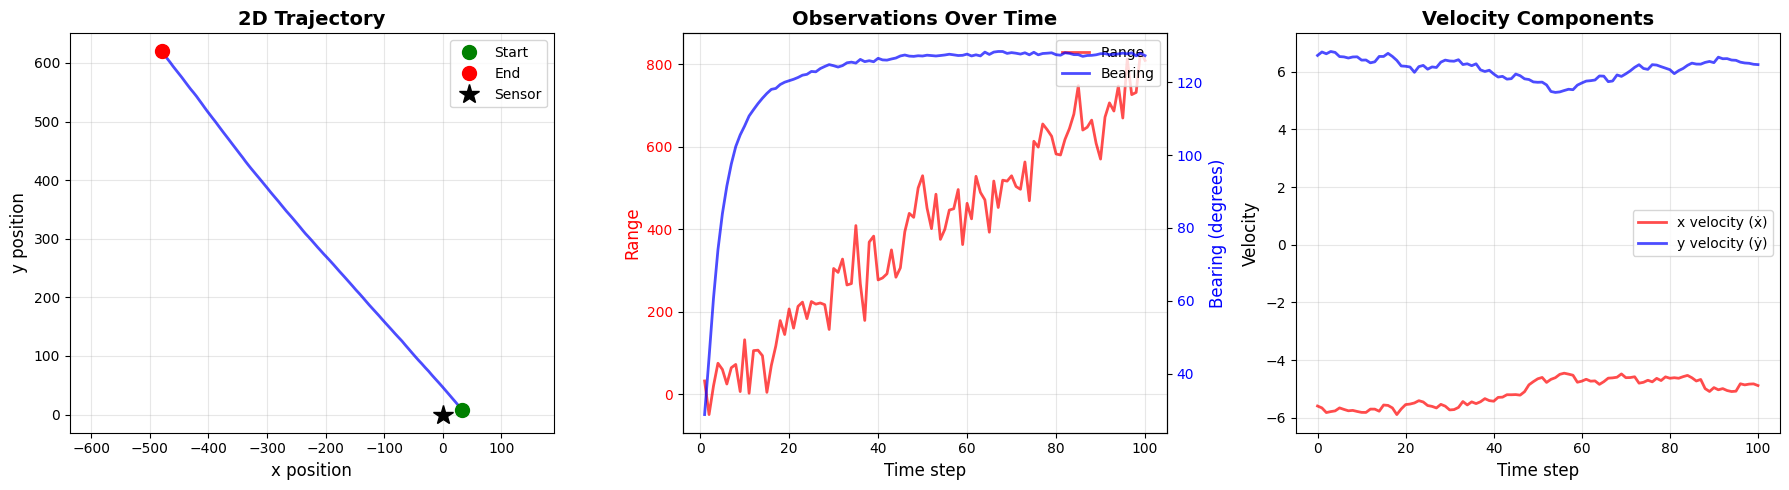

Visualization complete!


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: 2D trajectory
ax = axes[0]
ax.plot(states_np[0, :], states_np[2, :], 'b-', linewidth=2, alpha=0.7)
ax.plot(states_np[0, 0], states_np[2, 0], 'go', markersize=10, label='Start')
ax.plot(states_np[0, -1], states_np[2, -1], 'ro', markersize=10, label='End')
ax.plot(0, 0, 'k*', markersize=15, label='Sensor')
ax.set_xlabel('x position', fontsize=12)
ax.set_ylabel('y position', fontsize=12)
ax.set_title('2D Trajectory', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axis('equal')

# Plot 2: Range and bearing over time
ax = axes[1]
ax2 = ax.twinx()

time_obs = np.arange(1, T+1)
line1 = ax.plot(time_obs, obs_np[0, :], 'r-', linewidth=2, alpha=0.7, label='Range')
line2 = ax2.plot(time_obs, np.degrees(obs_np[1, :]), 'b-', linewidth=2, alpha=0.7, label='Bearing')

ax.set_xlabel('Time step', fontsize=12)
ax.set_ylabel('Range', fontsize=12, color='r')
ax2.set_ylabel('Bearing (degrees)', fontsize=12, color='b')
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')
ax.set_title('Observations Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right')

# Plot 3: Velocity components over time
ax = axes[2]
time_state = np.arange(0, T+1)
ax.plot(time_state, states_np[1, :], 'r-', linewidth=2, alpha=0.7, label='x velocity (ẋ)')
ax.plot(time_state, states_np[3, :], 'b-', linewidth=2, alpha=0.7, label='y velocity (ẏ)')
ax.set_xlabel('Time step', fontsize=12)
ax.set_ylabel('Velocity', fontsize=12)
ax.set_title('Velocity Components', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("Visualization complete!")